# Lagrange interpolation of 2D functions using the LGL points

In [12]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))

from matplotlib import pyplot as plt
import numpy as np
import arrayfire as af

from dg_maxwell import params
from dg_maxwell import utils
from dg_maxwell import lagrange
from dg_maxwell import wave_equation_2d as w2d

af.set_backend(params.backend)

In [142]:
N_LGL = 24
xi_LGL  = lagrange.LGL_points(N_LGL)
eta_LGL = lagrange.LGL_points(N_LGL)
Xi, Eta = utils.af_meshgrid(xi_LGL, eta_LGL)

_, Li_xi  = lagrange.lagrange_polynomials(xi_LGL)
_, Lj_eta = lagrange.lagrange_polynomials(eta_LGL)

Li_xi  = af.np_to_af_array(Li_xi)
Lj_eta = af.np_to_af_array(Lj_eta)
Lp_xi  = Li_xi.copy()
Lq_eta = Lj_eta.copy()

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1193: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)
/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:1220: FutureWarning: In the future extra properties will not be copied across when constructing one poly1d from another
  other = poly1d(other)


In [143]:
Li_Lp = utils.poly1d_product(Li_xi, Lp_xi)
Lj_Lq = utils.poly1d_product(Lj_eta, Lq_eta)

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


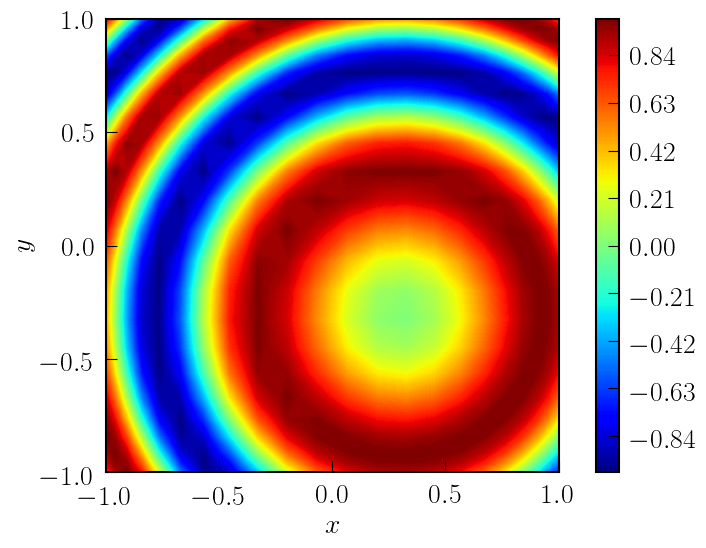

In [144]:
def gaussian_xy(x, y):
    return af.sin(4 * ((x - 0.3)**2 + (y + 0.3)**2))
#     return np.e**(-((x - 0.3)**2 + (y + 0.3)**2) / 0.6**2)

gaussian_xy_ij = gaussian_xy(Xi, Eta)

# print(gaussian_xy_ij)
plt.contourf(np.array(Xi), np.array(Eta), np.array(gaussian_xy_ij),
             200, cmap = 'jet')

plt.axes().set_aspect('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()

# plt.savefig('u_init.png')
plt.show()

In [145]:
# print(Lq_eta)
Lp_xi_tile = af.reorder(Lq_eta, d0 = 2, d1 = 0, d2 = 1)
Lp_xi_tile = af.tile(Lp_xi_tile, d0 = N_LGL)
Lp_xi_tile = af.moddims(Lp_xi_tile, d0 = N_LGL * N_LGL, d1 = 1, d2 = N_LGL)
Lp_xi_tile = af.reorder(Lp_xi_tile, d0 = 0, d1 = 2, d2 = 1)

Lq_eta_tile = af.reorder(Lq_eta, d0 = 0, d1 = 2, d2 = 1)
Lq_eta_tile = af.tile(Lq_eta_tile, d0 = N_LGL)
Lq_eta_tile = af.reorder(Lq_eta_tile, d0 = 0, d1 = 2, d2 = 1)

In [146]:
xi_linspace  = utils.linspace(-1, 1, 101)
eta_linspace = utils.linspace(-1, 1, 101)

Xi_linspace_mesh, Eta_linspace_mesh = utils.af_meshgrid(xi_linspace, eta_linspace)
Xi_linspace = af.flat(Xi_linspace_mesh)
Eta_linspace = af.flat(Eta_linspace_mesh)

In [147]:
# print(gaussian_xy_ij)
gaussian_ij_tile = af.flat(gaussian_xy_ij)
# print(gaussian_ij_tile)

In [148]:
Lp_tile_xi_linspace = utils.polyval_1d(Lp_xi_tile, Xi_linspace)
# print(Lp_tile_xi_linspace)

In [149]:
Lq_tile_eta_linspace = utils.polyval_1d(Lq_eta_tile, Eta_linspace)
# Lq_tile_eta_linspace = af.reorder(Lq_tile_eta_linspace, d0 = 0, d1 = 2, d2 = 1)
# Lq_tile_eta_linspace = af.tile(Lq_tile_eta_linspace, d0 = 1, d1 = Eta_linspace.shape[1], d2 = 1)
# print(Lq_tile_eta_linspace)

In [150]:
gaussian_interpolated = af.sum(af.tile(gaussian_ij_tile, d0 = 1, d1 = Lp_tile_xi_linspace.shape[1])
                               * Lp_tile_xi_linspace * Lq_tile_eta_linspace,
                               dim = 0)


/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


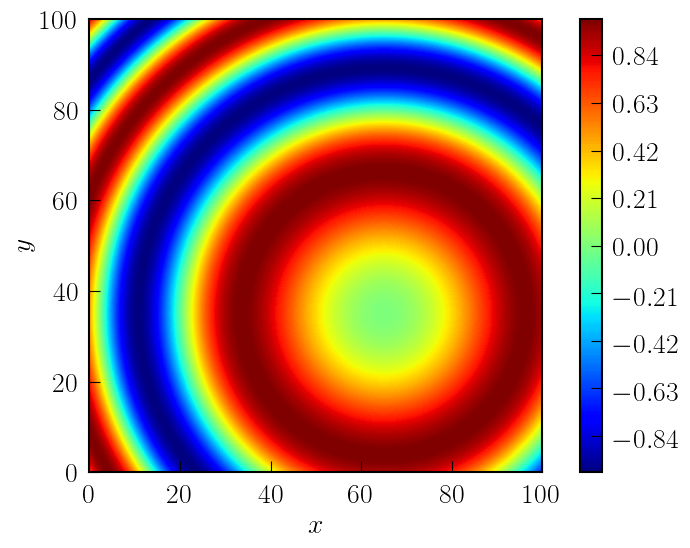

In [151]:
gaussian_interpolated = af.moddims(gaussian_interpolated, d0 = Xi_linspace_mesh.shape[0], d1 = Xi_linspace_mesh.shape[1])

plt.contourf(np.array(gaussian_interpolated), 200, cmap = 'jet')

plt.axes().set_aspect('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()

# plt.savefig('u_init.png')
plt.show()

/home/ubermensch/.local/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


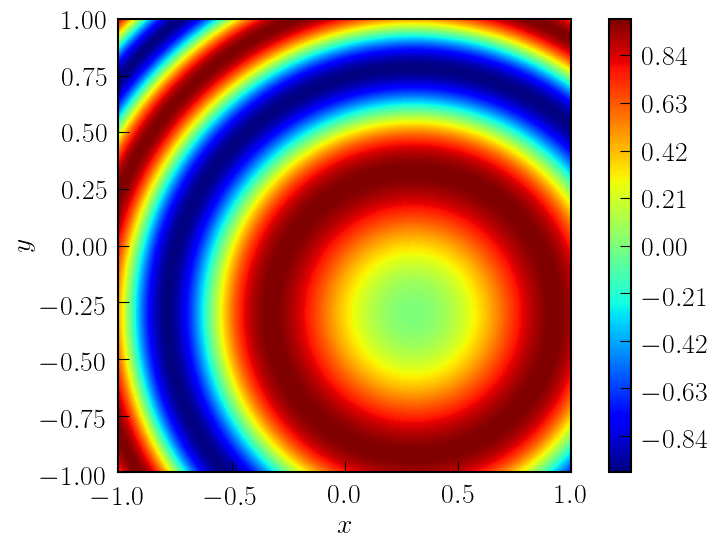

In [152]:
xi_ref  = utils.linspace(-1, 1, 101)
eta_ref = utils.linspace(-1, 1, 101)

xi_ref_mesh, eta_ref_mesh = utils.af_meshgrid(xi_ref, eta_ref)

plt.contourf(np.array(xi_ref_mesh), np.array(eta_ref_mesh),
             np.array(gaussian_xy(xi_ref_mesh, eta_ref_mesh)), 200, cmap = 'jet')

plt.axes().set_aspect('equal')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.colorbar()

# plt.savefig('u_init.png')
plt.show()